# The Boundaries of the Ocean #

Before dealing with the water itself, let's first examine the space that the water lives in.
This space is defined by the ocean bottom (the bathymetry) and the top (the free surface).

### Spatial Coordinates

Longitude: $\varphi$, Latitude: $\lambda$

### Boundaries

Bottom: $H = H(\varphi, \lambda)$, Surface: $\eta = \eta(\varphi, \lambda, t)$

_The ocean has no side boundaries!_

## The vertical coordinate: z

$z = 0$ at sea level

But what is sea level? Determined by the **geoid**: isosurfaces of gravitational + centrifugal potential.

![geoid](https://upload.wikimedia.org/wikipedia/commons/7/78/GRACE_globe_animation.gif)

### The Geoid

- Determined by distribution of mass within the Earth + planetary rotation rate
- Always perpendicular to gravity vector
- Varies on O(100 m) over Earth's surface

## The Free Surface

- Deviates from the geoid due to ocean mean circulation, waves, etc
- Varies on O(1 m)
- Negligible contribution to overall ocean volume

## The Bottom

To look at the bottom boundary of the ocean, we will load data from the
[NGDC ETOPO5 database](http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NGDC/.ETOPO5/.dataset_documentation.html) from the IRI Data Library.

In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (12,5)
import hvplot.xarray

In [2]:
ds = xr.open_dataset('http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NGDC/.ETOPO5/dods')
ds = ds.rename({'X': 'lon', 'Y': 'lat'})
ds['elev_ocean'] = ds.elev.where(ds.elev<0).load()
ds

<xarray.Dataset>
Dimensions:     (lat: 2160, lon: 4320)
Coordinates:
  * lat         (lat) float32 90.0 89.92 89.83 89.75 ... -89.75 -89.83 -89.92
  * lon         (lon) float32 0.0 0.08333 0.1667 0.25 ... 359.8 359.8 359.9
Data variables:
    elev        (lat, lon) int16 -4290 -4290 -4290 -4290 ... 2774 2774 2774 2774
    elev_ocean  (lat, lon) float64 -4.29e+03 -4.29e+03 -4.29e+03 ... nan nan nan
Attributes:
    description:                 ETOPO5 5x5 minute land surface elevations an...
    dataset_documentation.html:  http://iridl.ldeo.columbia.edu/SOURCES/.NOAA...
    Conventions:                 IRIDL

In [11]:
ds.elev_ocean.hvplot('lon', 'lat', clim=(-8000, 0), rasterize=True, height=500, width=1000, cmap='ocean')

:DynamicMap   []
   :Image   [lon,lat]   (elev_ocean)

## The Ocean Volume

Assuming spherical geometry

\begin{align}
  \mathcal{V} &= \iiint_{ocean} dV  \\
      &= \int_{-\pi}^{\pi} \int_{0}^{2 \pi} R^2 \cos(\lambda)d\lambda d \phi \int_{-H}^\eta dz \\
      &= \iint_{surface} (\eta + H)(\lambda, \phi) dA
\end{align}

Area element: $dA = R^2 \cos(\lambda)d\lambda d \phi$

In [4]:
# create a crude area weight factor based on assumption of spherical geometry
earth_radius =  6.371e6
tot_area = (4 * np.pi * earth_radius**2)
dlon = np.radians((ds['lon'][1]-ds['lon'][0]).values)
dlat = np.radians((ds['lat'][1]-ds['lat'][0]).values)
ds['area'] = earth_radius**2 * np.abs(dlon * dlat) * np.cos(np.radians(ds.lat)) * (0*ds.elev + 1)
ds['area_ocean'] = ds.area.where(ds.elev<0)
np.testing.assert_allclose(ds.area.sum().values, tot_area, rtol=1e-4)

How is the depth distributed? We can make a histogram of all the depths in the ocean (and on land) to visualize this.

(-8000.0, 6000.0)

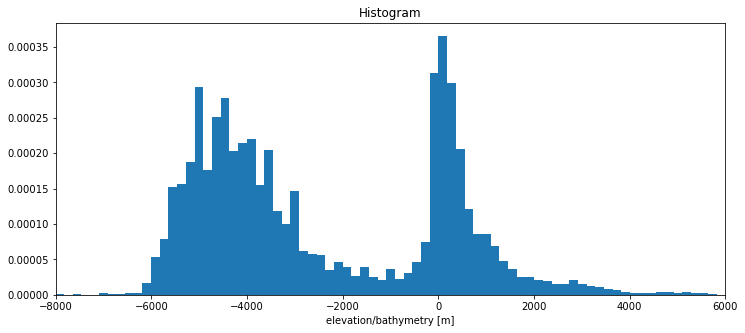

In [5]:
fig, ax = plt.subplots()
ds.elev.plot.hist(bins=100, weights=ds.area.values.ravel(), density=True, ax=ax);
ax.set_xlim([-8000,6000])

Everything above zero is land. We can see that most of the ocean volume lies between 6000 and 3000 m depth.

In [12]:
weights = ds.area_ocean.fillna(0)
print('Fraction of Earth Covered by Ocean:', ds.area_ocean.sum().values/tot_area)
print('Mean Ocean Depth:', float(ds.elev_ocean.weighted(weights).mean()), 'm')
print('Max Ocean Depth:', float(ds.elev_ocean.min()), 'm')
print('Total Ocean Volume:', -float(ds.elev_ocean.weighted(weights).sum()), 'm^3')

Fraction of Earth Covered by Ocean: 0.713957137139368
Mean Ocean Depth: -3674.6538377530514 m
Max Ocean Depth: -10376.0 m
Total Ocean Volume: 1.3381775119099261e+18 m^3


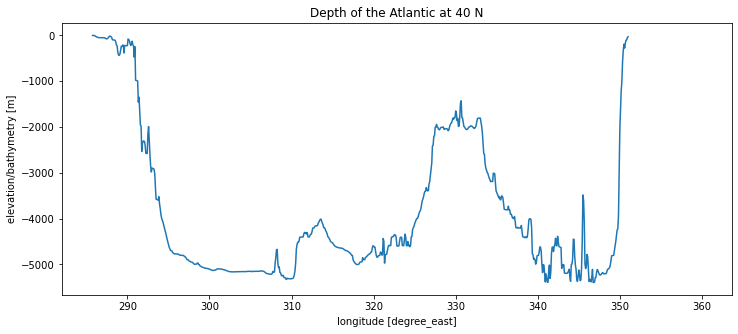

In [7]:
fig, ax = plt.subplots()
ds.elev_ocean.sel(lat=40, method='nearest').sel(lon=slice(270,360)).plot(ax=ax)
ax.set_title('Depth of the Atlantic at 40 N');

This section reveals many of the common characteristics of ocean basins:

- A shallow continential shelf approx. 200m deep at the edge.
- An _abyss_ about 5000 m deep.
- A steep mid-ocean ridge in the center of the basin reaching 2000m depth.

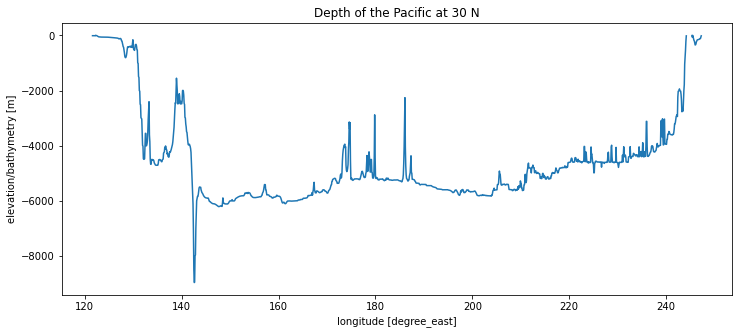

In [9]:
fig, ax = plt.subplots()
ds.elev_ocean.sel(lat=30, method='nearest').sel(lon=slice(120,250)).plot(ax=ax)
ax.set_title('Depth of the Pacific at 30 N');

The Pacific looks similar in many ways. We also see the extremely deep Mariana trench at the Western edge of the basin. _What geophysical processes explain these features?_

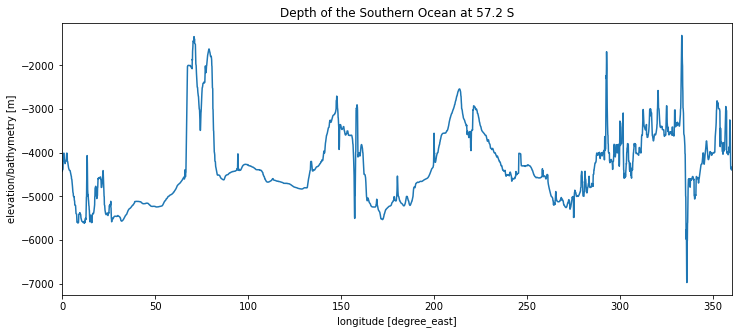

In [10]:
fig, ax = plt.subplots()
ds.elev_ocean.sel(lat=-57.2, method='nearest').plot(ax=ax)
ax.set_title('Depth of the Southern Ocean at 57.2 S')
ax.set_xlim([0,360]);

The Southern Ocean is very different because there is a narrow range of latitudes at which no bathymetry reaches the surface. This has major consequeces for ocean circulation, which we will learn about later on in the course.